Crear conexión SPARK


In [18]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Creación y aplicación del modelo").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("Ejcución de las tareas en ", cores, "core(s) del sistema de cómputo actual")

Ejcución de las tareas en  1 core(s) del sistema de cómputo actual


Carga de datos


In [19]:
from pyspark import SparkFiles
from google.colab import drive


drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Resultados_icfes_limpios (1).csv'

df00 = spark.read.csv(dataset_path, header=True, inferSchema=True)
df00.show(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+-----------+----------------+------------------------+----------------+--------------------+-----------+-----------------------+-----------------------+-----------------------+---------------+---------------+-----------------------------------+-----------------------------------+-------------+-------------+----------+----+-------------------------+-------------------------+---------------------------+-----------------------+---------------+-----------------+---------------+------------+------------+-----------+
|PUNT_GLOBAL|PUNT_C_NATURALES|PUNT_SOCIALES_CIUDADANAS|PUNT_MATEMATICAS|PUNT_LECTURA_CRITICA|PUNT_INGLES|madre_PRIMARIA_COMPLETA|padre_PREGRADO_COMPLETO|padre_PRIMARIA_COMPLETA|padre_POSTGRADO|madre_POSTGRADO|madre_TECNICO_O_TECNOLOGIA_COMPLETA|padre_TECNICO_O_TECNOLOGIA_COMPLETA|madre_NINGUNA|padre_NINGUNA|TRIMESTRES| AÑO|madre_PRIMARIA_INCOMPLETA|ma

Antes de realizar el modelo tenemos que modificar el nombre de una columna pues puede generar problemas

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


df01 = df00.withColumnRenamed(" AÑO", "ANIO")

# Definir columnas


In [21]:
categorical_cols = [
    "COLE_CALENDARIO", "COLE_CARACTER",
    "COLE_NATURALEZA", "COLE_JORNADA",
    "DEPARTAMENTO", "ESTU_GENERO"
]

all_cols = df01.columns
numeric_cols = [
    c for c in all_cols
    if c not in categorical_cols + ["PUNT_GLOBAL", "ANIO"]
    and not c.startswith("PUNT_")
]

# Pipeline de preprocesamiento


Indexar categorías

In [22]:
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in categorical_cols
]

One-hot encoding


In [23]:
encoder = OneHotEncoder(
    inputCols=[f"{col}_idx" for col in categorical_cols],
    outputCols=[f"{col}_ohe" for col in categorical_cols],
    handleInvalid="keep"
)



Ensamblar vector de features


In [24]:
feature_cols = numeric_cols + [f"{col}_ohe" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

prep_pipeline = Pipeline(stages=indexers + [encoder, assembler])
prep_model = prep_pipeline.fit(df01)
df_prepped = prep_model.transform(df01).select("features", "PUNT_GLOBAL")

#  Modelo Ridge (LinearRegression con regParam)

In [25]:
ridge = LinearRegression(
    featuresCol="features",
    labelCol="PUNT_GLOBAL",
    elasticNetParam=0.0,
    regParam=0.1
)
ridge_model = ridge.fit(df_prepped)

print("Intercept Ridge =", ridge_model.intercept)

Intercept Ridge = -4366.989316421158


Sacamos los coeficientes más grandes en magnitud


In [26]:
import pandas as pd
coef_list = list(zip(feature_cols, ridge_model.coefficients.toArray()))
coef_df = pd.DataFrame(coef_list, columns=["feature","coef"])
coef_df["abs_coef"] = coef_df["coef"].abs()
print("Top 10 coeficientes por magnitud:")
print(coef_df.sort_values("abs_coef", ascending=False).head(10))

Top 10 coeficientes por magnitud:
                                feature       coef   abs_coef
16                    COLE_CARACTER_ohe  34.653485  34.653485
3                       padre_POSTGRADO  32.143251  32.143251
17                  COLE_NATURALEZA_ohe -29.957351  29.957351
4                       madre_POSTGRADO  29.487931  29.487931
14              madre_PREGRADO_COMPLETO  16.263185  16.263185
1               padre_PREGRADO_COMPLETO  15.943977  15.943977
7                         madre_NINGUNA -15.553105  15.553105
9                            TRIMESTRES  13.903334  13.903334
5   madre_TECNICO_O_TECNOLOGIA_COMPLETA  10.912593  10.912593
6   padre_TECNICO_O_TECNOLOGIA_COMPLETA  10.081134  10.081134


In [27]:
# 2. Definir columnas categóricas
categorical_cols = [
    "COLE_CALENDARIO", "COLE_CARACTER",
    "COLE_NATURALEZA", "COLE_JORNADA",
    "DEPARTAMENTO", "ESTU_GENERO"
]

# 3. Excluir las sub-puntuaciones de numeric_cols
all_cols = df01.columns
numeric_cols = [
    c for c in all_cols
    if c not in categorical_cols + ["PUNT_GLOBAL", "ANIO"]
    and not c.startswith("PUNT_")
]

# 4. Preparar pipeline
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in categorical_cols
]
encoder = OneHotEncoder(
    inputCols=[f"{col}_idx" for col in categorical_cols],
    outputCols=[f"{col}_ohe" for col in categorical_cols],
    handleInvalid="keep"
)
feature_cols = numeric_cols + [f"{col}_ohe" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

pipeline = Pipeline(stages=indexers + [encoder, assembler])
model_prep = pipeline.fit(df01)
df_feat = model_prep.transform(df01).select("features", "PUNT_GLOBAL")

# 5. Entrenar Ridge únicamente con variables socioeconómicas e institucionales
ridge2 = LinearRegression(
    featuresCol="features",
    labelCol="PUNT_GLOBAL",
    elasticNetParam=0.0,
    regParam=0.1
)
ridge_model2 = ridge2.fit(df_feat)

# 6. Mostrar resultados
print("Intercept Ridge ajustado =", ridge_model2.intercept)

coef_list2 = list(zip(feature_cols, ridge_model2.coefficients.toArray()))
coef_df2 = pd.DataFrame(coef_list2, columns=["feature","coef"])
coef_df2["abs_coef"] = coef_df2["coef"].abs()

print("Top 10 variables (sin sub-puntuaciones):")
print(coef_df2.sort_values("abs_coef", ascending=False).head(10))



Intercept Ridge ajustado = -4366.989316421158
Top 10 variables (sin sub-puntuaciones):
                                feature       coef   abs_coef
16                    COLE_CARACTER_ohe  34.653485  34.653485
3                       padre_POSTGRADO  32.143251  32.143251
17                  COLE_NATURALEZA_ohe -29.957351  29.957351
4                       madre_POSTGRADO  29.487931  29.487931
14              madre_PREGRADO_COMPLETO  16.263185  16.263185
1               padre_PREGRADO_COMPLETO  15.943977  15.943977
7                         madre_NINGUNA -15.553105  15.553105
9                            TRIMESTRES  13.903334  13.903334
5   madre_TECNICO_O_TECNOLOGIA_COMPLETA  10.912593  10.912593
6   padre_TECNICO_O_TECNOLOGIA_COMPLETA  10.081134  10.081134


In [28]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Dividir en 80% train / 20% test
train_ridge, test_ridge = df_feat.randomSplit([0.8, 0.2], seed=42)

# 2. Ajustar Ridge sobre el train
ridge_eval = LinearRegression(
    featuresCol="features",
    labelCol="PUNT_GLOBAL",
    elasticNetParam=0.0,  # Ridge
    regParam=0.1
)
model_ridge_eval = ridge_eval.fit(train_ridge)

# 3. Predecir sobre el test
pred_ridge = model_ridge_eval.transform(test_ridge)

# 4. Calcular métricas
evaluator_rmse = RegressionEvaluator(
    labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="rmse")
evaluator_r2   = RegressionEvaluator(
    labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="r2")

rmse_ridge = evaluator_rmse.evaluate(pred_ridge)
r2_ridge   = evaluator_r2.evaluate(pred_ridge)

print(f"Ridge on test → RMSE: {rmse_ridge:.3f},  R²: {r2_ridge:.3f}")


Ridge on test → RMSE: 39.451,  R²: 0.312


# Análisis no supervisado de perfiles socio-económicos en PySpark


In [29]:

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg
import pandas as pd


# 1. Cargar y preparar DataFrame inicial
df_raw = spark.read.csv("/content/drive/MyDrive/Resultados_icfes_limpios (1).csv",
                        header=True, inferSchema=True)
df_raw = df_raw.withColumnRenamed(" AÑO", "ANIO")

# 2. Definir variables
categorical_cols = ["COLE_CALENDARIO","COLE_CARACTER",
                    "COLE_NATURALEZA","COLE_JORNADA",
                    "DEPARTAMENTO","ESTU_GENERO"]
exclude = [c for c in df_raw.columns if c.startswith("PUNT_") and c != "PUNT_GLOBAL"]
numeric_cols = [c for c in df_raw.columns
                if c not in categorical_cols + ["PUNT_GLOBAL","ANIO"] + exclude]

# 3. Pipeline de preprocesamiento
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in categorical_cols
]
encoder = OneHotEncoder(
    inputCols=[f"{col}_idx" for col in categorical_cols],
    outputCols=[f"{col}_ohe" for col in categorical_cols],
    handleInvalid="keep"
)
feature_cols = numeric_cols + [f"{col}_ohe" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

prep_pipeline = Pipeline(stages=indexers + [encoder, assembler])
prep_model = prep_pipeline.fit(df_raw)
df_feat2 = prep_model.transform(df_raw).select("features")

# 4. Escalamiento
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
df_scaled = scaler.fit(df_feat2).transform(df_feat2)

# 5. PCA
pca = PCA(k=5, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# 6. Búsqueda de k óptimo
evaluator = ClusteringEvaluator(featuresCol="pcaFeatures",
                                metricName="silhouette",
                                distanceMeasure="squaredEuclidean")
best_k, best_score = None, -1.0
for k in range(2, 7):
    km = KMeans(featuresCol="pcaFeatures", k=k, seed=42)
    score = evaluator.evaluate(km.fit(df_pca).transform(df_pca))
    print(f"Silhouette para k={k}: {score:.4f}")
    if score > best_score:
        best_k, best_score = k, score
print(f"\nMejor k = {best_k} (Silhouette = {best_score:.4f})")

# 7. Ajuste final de KMeans
kmeans = KMeans(featuresCol="pcaFeatures", predictionCol="cluster",
                k=best_k, seed=42)
model_km = kmeans.fit(df_pca)
clusters = model_km.transform(df_pca)

# 8. Tamaño de clusters
clusters.groupBy("cluster").count().orderBy("cluster").show()

# 9. Centros de clusters
for idx, center in enumerate(model_km.clusterCenters()):
    print(f"Cluster {idx} center: {center}")

# 10. Cargas de PC1 y PC2
loadings = pca_model.pc.toArray()
pc1 = sorted(zip(feature_cols, loadings[:,0]), key=lambda x: abs(x[1]), reverse=True)[:10]
pc2 = sorted(zip(feature_cols, loadings[:,1]), key=lambda x: abs(x[1]), reverse=True)[:10]
print("\nTop 10 cargas PC1:", pc1)
print("\nTop 10 cargas PC2:", pc2)

# 11. Caracterizar clusters en variables originales
df_with_cluster = prep_model.transform(df_raw) \
                   .join(clusters.select("features","cluster"), on="features")

agg_exprs = [avg(c).alias(f"avg_{c}") for c in numeric_cols] \
          + [avg(f"{col}_idx").alias(f"avg_{col}") for col in categorical_cols]
df_with_cluster.groupBy("cluster").agg(*agg_exprs).show(truncate=False)


Silhouette para k=2: 0.5497
Silhouette para k=3: 0.3101
Silhouette para k=4: 0.3882
Silhouette para k=5: 0.3628
Silhouette para k=6: 0.4237

Mejor k = 2 (Silhouette = 0.5497)
+-------+------+
|cluster| count|
+-------+------+
|      0|538541|
|      1|131988|
+-------+------+

Cluster 0 center: [ 104.51982788    4.04416166 -248.1764441   -69.24093458  -28.74019687]
Cluster 1 center: [ 108.49970358    4.48868786 -247.01431389  -69.30055924  -28.78263912]

Top 10 cargas PC1: [('COLE_CALENDARIO_ohe', np.float64(-0.32439986688537614)), ('COLE_CARACTER_ohe', np.float64(0.307135594356976)), ('TRIMESTRES', np.float64(-0.29684495599277083)), ('DEPARTAMENTO_ohe', np.float64(0.2549375407320688)), ('ESTU_GENERO_ohe', np.float64(-0.2245698842510098)), ('madre_PREGRADO_COMPLETO', np.float64(0.19234829200833403)), ('padre_PREGRADO_COMPLETO', np.float64(0.18120859846862858)), ('padre_POSTGRADO', np.float64(0.17300675355484477)), ('madre_POSTGRADO', np.float64(0.15584223041590034)), ('padre_PRIMARIA_C

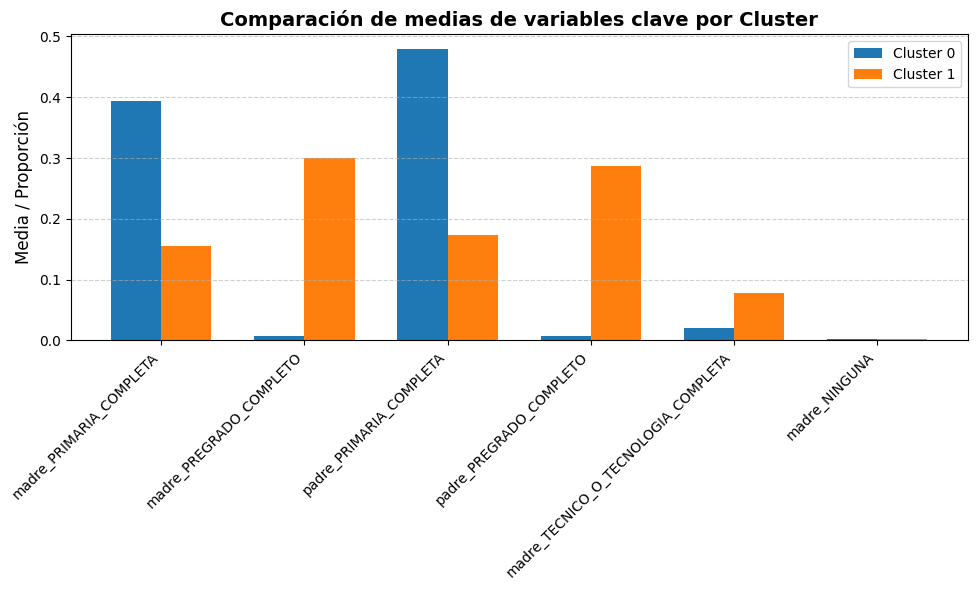

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import avg

# 1. Selecciona un pequeño grupo de variables clave
key_vars = [
    "madre_PRIMARIA_COMPLETA",
    "madre_PREGRADO_COMPLETO",
    "padre_PRIMARIA_COMPLETA",
    "padre_PREGRADO_COMPLETO",
    "madre_TECNICO_O_TECNOLOGIA_COMPLETA",
    "madre_NINGUNA"
]

# 2. Calcula la media de esas variables por cluster
agg_df = df_with_cluster.groupBy("cluster").agg(
    *[avg(c).alias(c) for c in key_vars]
).toPandas().set_index("cluster")

# 3. Gráfico de barras comparativo
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(key_vars))
width = 0.35

ax.bar([i - width/2 for i in x], agg_df.loc[0, key_vars], width, label="Cluster 0")
ax.bar([i + width/2 for i in x], agg_df.loc[1, key_vars], width, label="Cluster 1")

ax.set_xticks(x)
ax.set_xticklabels(key_vars, rotation=45, ha="right")
ax.set_ylabel("Media / Proporción", fontsize=12)
ax.set_title("Comparación de medias de variables clave por Cluster", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


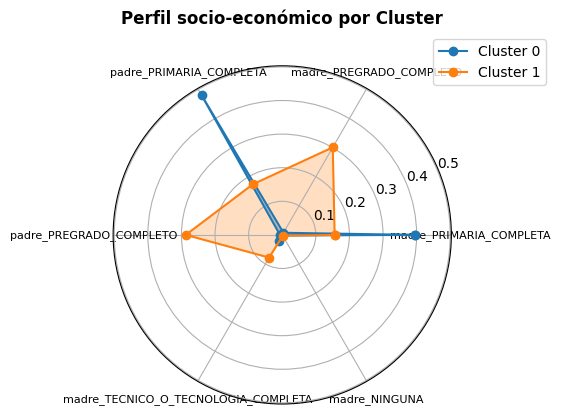

In [31]:
import numpy as np
import matplotlib.pyplot as plt

labels = key_vars
stats0 = agg_df.loc[0, labels].values
stats1 = agg_df.loc[1, labels].values

# Cerrar el polígono
stats0 = np.concatenate((stats0, [stats0[0]]))
stats1 = np.concatenate((stats1, [stats1[0]]))
angles = np.linspace(0, 2*np.pi, len(labels)+1, endpoint=True)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats0, 'o-', label='Cluster 0')
ax.fill(angles, stats0, alpha=0.25)
ax.plot(angles, stats1, 'o-', label='Cluster 1')
ax.fill(angles, stats1, alpha=0.25)
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels, fontsize=8)
ax.set_title("Perfil socio-económico por Cluster", y=1.1, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


<ipython-input-32-4a94906f4346>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Cluster 0','Cluster 1'])


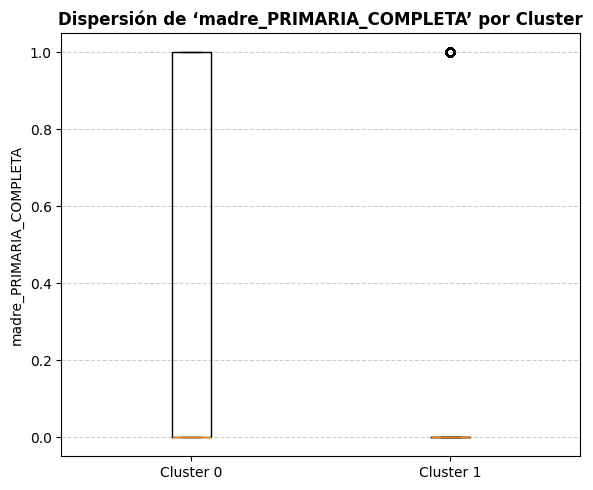

In [32]:
sampled = df_with_cluster.sampleBy("cluster", fractions={0: 0.01, 1: 0.01}, seed=42)
pdf_samp = sampled.select("cluster", "madre_PRIMARIA_COMPLETA").toPandas()

plt.figure(figsize=(6,5))
data0 = pdf_samp[pdf_samp.cluster==0]["madre_PRIMARIA_COMPLETA"]
data1 = pdf_samp[pdf_samp.cluster==1]["madre_PRIMARIA_COMPLETA"]
plt.boxplot([data0, data1], labels=['Cluster 0','Cluster 1'])
plt.ylabel("madre_PRIMARIA_COMPLETA")
plt.title("Dispersión de ‘madre_PRIMARIA_COMPLETA’ por Cluster", fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
